# Classification model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import pkg_resources
root_packages = ['pandas', 'matplotlib', 'seaborn', 'numpy', 'scikit-learn']

for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

seaborn==0.10.1
scikit-learn==0.24.1
pandas==1.1.4
numpy==1.20.1
matplotlib==3.2.2


In [2]:
SEED = 1

## Data Preparation

In [3]:
url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/data/back_pain.csv"
df = pd.read_csv(url) # download heart dataset
attr = df[df.columns[1:13]]
target = df[df.columns[13]]

#X_train, X_test, y_train, y_test = train_test_split(attr, 
                                                    #target, 
                                                   # test_size=0.33, 
                                                  #  random_state=SEED)
col_list = list(df.iloc[:, -1].dropna().unique())
col_list = [c.split('=')[-1] for c in col_list]
del col_list[0]

df = df.iloc[:, :-1]
df.columns = col_list

df.loc[df['Attribute class {Abnormal, Normal} '] == 'Abnormal',\
              'Attribute class {Abnormal, Normal} '] = 0
df.loc[df['Attribute class {Abnormal, Normal} '] != 0,\
              'Attribute class {Abnormal, Normal} '] = 1

raw_X = df[df.columns[0:12]]
raw_y = df[df.columns[12]]
raw_y = pd.Series(raw_y, dtype='int64')
raw_y

0      0
1      0
2      0
3      0
4      0
      ..
305    1
306    1
307    1
308    1
309    1
Name: Attribute class {Abnormal, Normal} , Length: 310, dtype: int64

## Helper functions

In [4]:
def get_preds(model, X_test):
    return model.predict(X_test)

def get_metric_scores(y_test, preds):
    acc = metrics.accuracy_score(y_test, preds)
    prec = metrics.precision_score(y_test, preds) 
    rec = metrics.recall_score(y_test, preds)
    return [acc, prec, rec]

def get_roc(y_test, preds, label):
    fpr, tpr, thresh = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label= str(label) + " AUC = " + str(auc))
    plt.legend(loc=0)

In [5]:
def get_models(X_train, y_train, random_state=SEED):
    lrm = LogisticRegression(random_state=SEED).fit(X_train, y_train)
    rfm = RandomForestClassifier(random_state=SEED).fit(X_train, y_train)
    nnm = MLPClassifier(random_state=SEED).fit(X_train, y_train)
    return lrm, rfm, nnm

def get_comparison_grid(models, X_test, y_test, _type):
    preds = []
    scores = []

    for i in models:
        preds.append(get_preds(i, X_test))

    for i in preds:
        scores.append(get_metric_scores(y_test, i))
        
    scores = pd.DataFrame(scores)
    scores.columns =['Accuracy', 'Precision', 'Recall']
    scores.index = [_type+' Logistic Regression', _type+' Random Forest', _type+' Neural Network']
    return scores

def create_matrix(y_test, preds, model, labels):
    cm = metrics.confusion_matrix(y_test, preds)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    plt.title(f'Confusion Matrix: {model}');

## ML Evaluation - synthetic data generation via PCA 

### Data generation

In [6]:
url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/syn_data/pca_df.csv"
df2 = pd.read_csv(url)
syn_X = df2[df2.columns[0:12]]
syn_y = df2[df2.columns[12]]
## initalise for synthetic datasets

In [7]:
syn_y

0      0.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
305    1.0
306    1.0
307    1.0
308    0.0
309    1.0
Name: state, Length: 310, dtype: float64

### Training and evaluation

In [8]:
models = get_models(syn_X, syn_y, random_state=SEED) # train models

preds_raw = [] # test data, ie the raw data
preds_syn = [] # train data, ie the synthetic data
for i in models:
    preds_raw.append(get_preds(i, raw_X))
    preds_syn.append(get_preds(i, syn_X))
    
a = get_comparison_grid(models, raw_X, raw_y, 'Raw - ')
b = get_comparison_grid(models, syn_X, syn_y, 'Syn. - ')
pd.concat([a,b])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Accuracy,Precision,Recall
Raw - Logistic Regression,0.774194,0.602740,0.880000
Raw - Random Forest,0.819355,0.659420,0.910000
Raw - Neural Network,0.783871,0.607843,0.930000
Syn. - Logistic Regression,0.832258,0.801170,0.883871
Syn. - Random Forest,1.000000,1.000000,1.000000
Syn. - Neural Network,0.948387,0.911243,0.993548


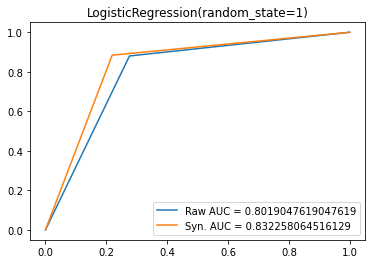

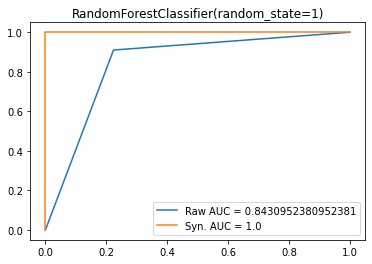

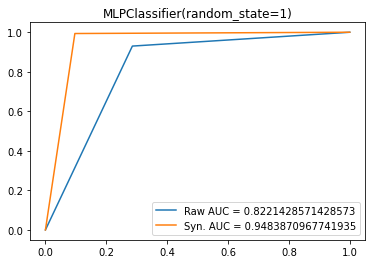

In [9]:
for i,j,k in zip(preds_raw, preds_syn, models):
    fig, ax = plt.subplots(1, 1)
    plt.title(k)
    get_roc(raw_y, i, 'Raw')
    get_roc(syn_y, j, 'Syn.')

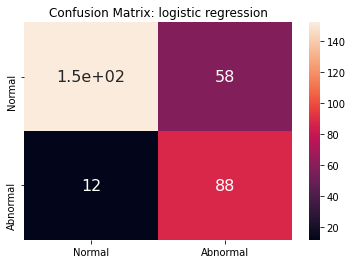

In [10]:
labels = ['Normal', 'Abnormal']
create_matrix(raw_y, preds_raw[0], 'logistic regression', labels)

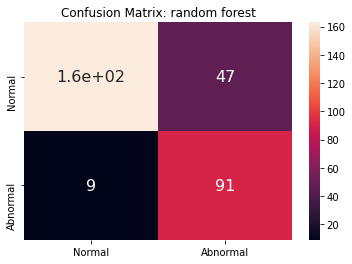

In [11]:
create_matrix(raw_y, preds_raw[1], 'random forest', labels)

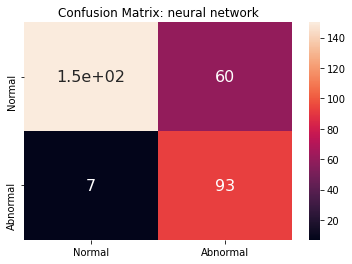

In [12]:
create_matrix(raw_y, preds_raw[2], 'neural network', labels)

## ML Evaluation - synthetic data generation via SMOTE

### Data generation

In [13]:
syn_X = 1 # synthetic attributes 
syn_y = 1 # synthetic targets

url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/syn_data/smoteX.csv"
syn_X = pd.read_csv(url)
syn_X.reset_index
syn_X = syn_X.drop(columns=['Unnamed: 0'])

url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/syn_data/smotey.csv"
syn_y = pd.read_csv(url)
syn_y.reset_index
syn_y = syn_y.drop(columns=['Unnamed: 0'])
## initalise for synthetic datasets

### Training and evaluation

In [14]:
models = get_models(syn_X, syn_y, random_state=SEED) # train models

preds_raw = [] # test data, ie the raw data
preds_syn = [] # train data, ie the synthetic data
for i in models:
    preds_raw.append(get_preds(i, raw_X))
    preds_syn.append(get_preds(i, syn_X))
    
a = get_comparison_grid(models, raw_X, raw_y, 'Raw - ')
b = get_comparison_grid(models, syn_X, syn_y, 'Syn. - ')
pd.concat([a,b])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-5-cc5478fc3e2c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfm = RandomForestCl

,Accuracy,Precision,Recall
Raw - Logistic Regression,0.851613,0.764706,0.78
Raw - Random Forest,0.912903,0.901099,0.82
Raw - Neural Network,0.870968,0.800000,0.80
Syn. - Logistic Regression,0.896774,0.840000,0.84
Syn. - Random Forest,1.000000,1.000000,1.00
Syn. - Neural Network,0.932258,0.891089,0.90


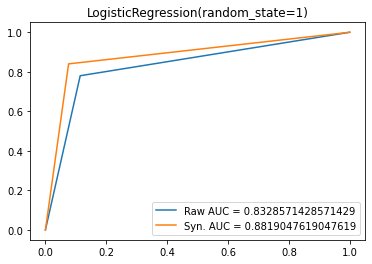

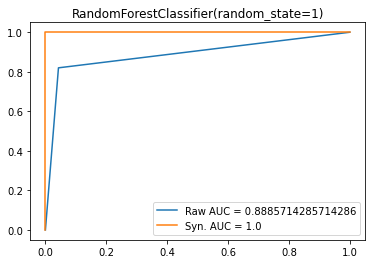

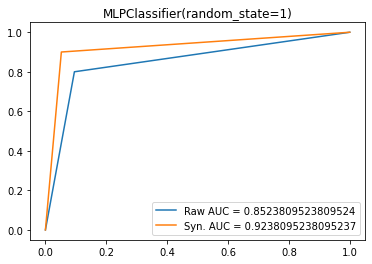

In [15]:
for i,j,k in zip(preds_raw, preds_syn, models):
    fig, ax = plt.subplots(1, 1)
    plt.title(k)
    get_roc(raw_y, i, 'Raw')
    get_roc(syn_y, j, 'Syn.')

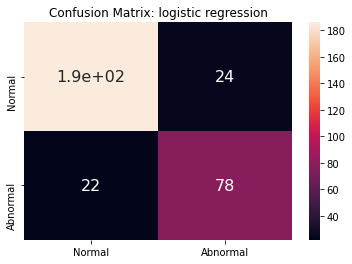

In [16]:
create_matrix(raw_y, preds_raw[0], 'logistic regression', labels)

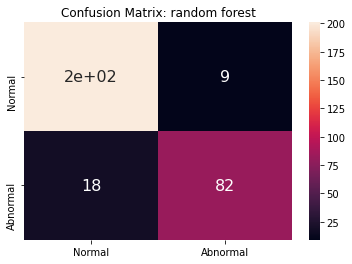

In [17]:
create_matrix(raw_y, preds_raw[1], 'random forest', labels)

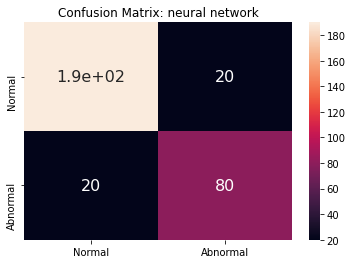

In [18]:
create_matrix(raw_y, preds_raw[2], 'neural network', labels)

## ML Evaluation - synthetic data generation via CTGAN

### Data generation - Mike's code

In [19]:
url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/syn_data/back_pain_ctgan_mike_v4.csv"
df3 = pd.read_csv(url)
#df3 = df3.drop(columns=['Unnamed: 0'])

df3.loc[df3['Class_att'] == 'Abonormal',\
              'Class_att'] = 0
df3.loc[df3['Class_att'] != 0,\
              'Class_att'] = 1
syn_X = df3[df3.columns[0:12]]
syn_y = df3[df3.columns[12]]
syn_y = pd.Series(syn_y, dtype='int64')
## initalise for synthetic datasets

### Training and evaluation - Mike's code

In [20]:
models = get_models(syn_X, syn_y, random_state=SEED) # train models

preds_raw = [] # test data, ie the raw data
preds_syn = [] # train data, ie the synthetic data
for i in models:
    preds_raw.append(get_preds(i, raw_X))
    preds_syn.append(get_preds(i, syn_X))
    
a = get_comparison_grid(models, raw_X, raw_y, 'Raw - ')
b = get_comparison_grid(models, syn_X, syn_y, 'Syn. - ')
pd.concat([a,b])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy,Precision,Recall
Raw - Logistic Regression,0.754839,0.588235,0.800000
Raw - Random Forest,0.780645,0.666667,0.640000
Raw - Neural Network,0.732258,0.556291,0.840000
Syn. - Logistic Regression,0.996774,1.000000,0.993548
Syn. - Random Forest,1.000000,1.000000,1.000000
Syn. - Neural Network,1.000000,1.000000,1.000000


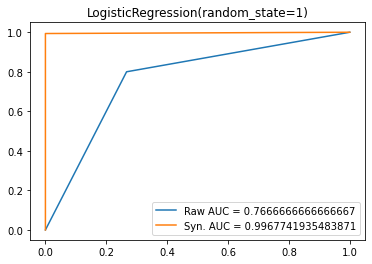

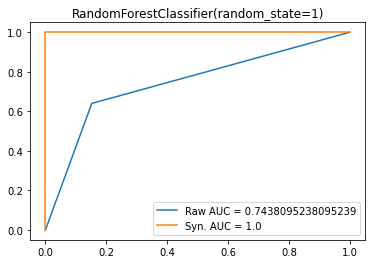

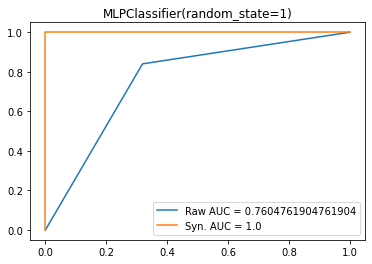

In [21]:
for i,j,k in zip(preds_raw, preds_syn, models):
    fig, ax = plt.subplots(1, 1)
    plt.title(k)
    get_roc(raw_y, i, 'Raw')
    get_roc(syn_y, j, 'Syn.')

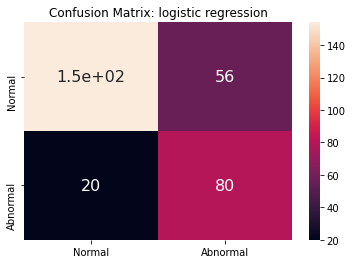

In [22]:
create_matrix(raw_y, preds_raw[0], 'logistic regression', labels)

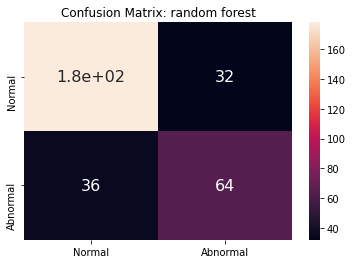

In [23]:
create_matrix(raw_y, preds_raw[1], 'random forest', labels)

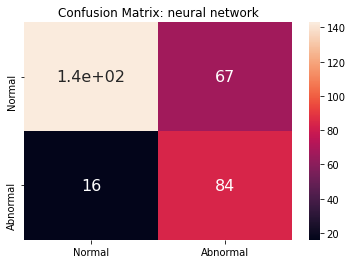

In [24]:
create_matrix(raw_y, preds_raw[2], 'neural network', labels)

### Data generation - Sammi's code

In [25]:
url = "https://raw.githubusercontent.com/jamestgodwin/synthetic_data/main/syn_data/back_pain_copulagan_bergam0t_v3.csv"
df3 = pd.read_csv(url)
df3 = df3.drop(columns=['Unnamed: 0'])

df3.loc[df3['Class_att'] == 'Abnormal',\
              'Class_att'] = 0
df3.loc[df3['Class_att'] != 0,\
              'Class_att'] = 1
syn_X = df3[df3.columns[0:12]]
syn_y = df3[df3.columns[12]]
syn_y = pd.Series(syn_y, dtype='int64')
## initalise for synthetic datasets

### Training and evaluation - Sammi's code

In [26]:
models = get_models(syn_X, syn_y, random_state=SEED) # train models

preds_raw = [] # test data, ie the raw data
preds_syn = [] # train data, ie the synthetic data
for i in models:
    preds_raw.append(get_preds(i, raw_X))
    preds_syn.append(get_preds(i, syn_X))
    
a = get_comparison_grid(models, raw_X, raw_y, 'Raw - ')
b = get_comparison_grid(models, syn_X, syn_y, 'Syn. - ')
pd.concat([a,b])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Accuracy,Precision,Recall
Raw - Logistic Regression,0.683871,0.516129,0.320000
Raw - Random Forest,0.719355,0.594203,0.410000
Raw - Neural Network,0.664516,0.473684,0.360000
Syn. - Logistic Regression,0.893548,0.831579,0.822917
Syn. - Random Forest,1.000000,1.000000,1.000000
Syn. - Neural Network,0.922581,0.891304,0.854167


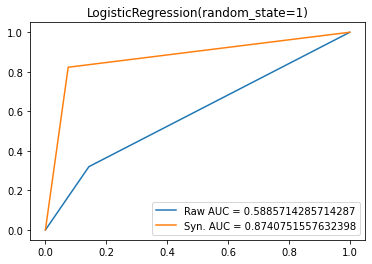

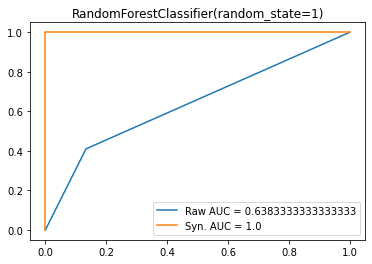

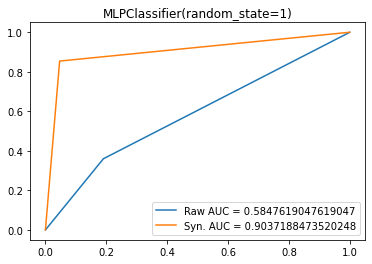

In [27]:
for i,j,k in zip(preds_raw, preds_syn, models):
    fig, ax = plt.subplots(1, 1)
    plt.title(k)
    get_roc(raw_y, i, 'Raw')
    get_roc(syn_y, j, 'Syn.')

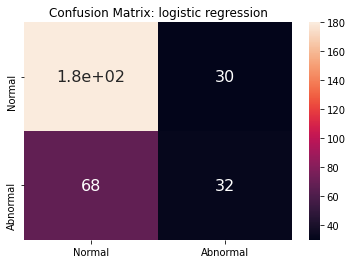

In [28]:
create_matrix(raw_y, preds_raw[0], 'logistic regression', labels)

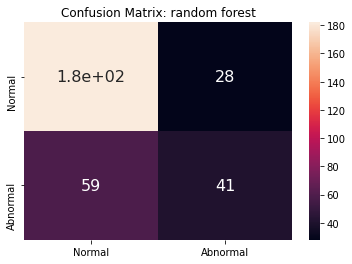

In [29]:
create_matrix(raw_y, preds_raw[1], 'random forest', labels)

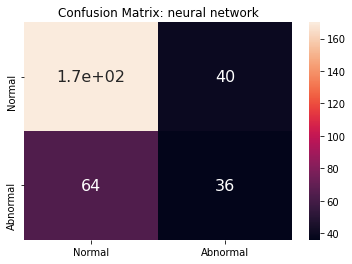

In [30]:
create_matrix(raw_y, preds_raw[2], 'neural network', labels)